In [1]:
# Basic modules 
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd 
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import load_img
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import random
import os
import shutil

# For Model Creation 
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout, GaussianNoise, GaussianDropout
from keras.layers import Flatten, BatchNormalization
from keras.layers.convolutional import Conv2D, SeparableConv2D, AveragePooling2D
from keras.constraints import maxnorm
from keras.layers.convolutional import MaxPooling2D
from keras.utils import np_utils
from keras import backend as K
from keras import regularizers, optimizers
from keras.optimizers import Adam

In [2]:
path = r'archive'

In [3]:
train = pd.read_csv(path+'/trainData.csv')

image = (path+"/trainImgs/trainImgs/44e951e45dca.png")

In [4]:
print(train.head())
train.shape

       id_code  diagnosis
0  35867_right          3
1   4620_right          3
2   12063_left          1
3    9680_left          4
4  16727_right          3


(7243, 2)

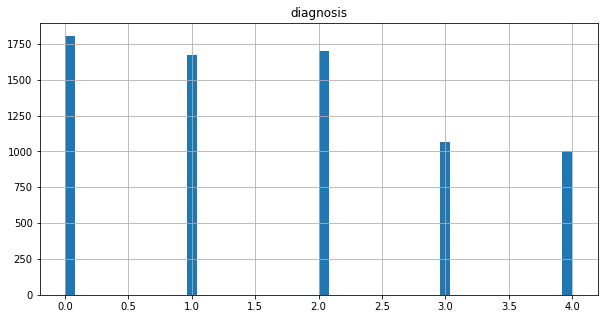

In [5]:
train.hist(bins=50,figsize=(10,5))
plt.show()

In [6]:
from sklearn.model_selection import train_test_split
train['diagnosis'] =  train['diagnosis'].astype(str)
train['diagnosis'] =  train['diagnosis'].astype('string')
train['id_code'] =  train['id_code'].astype(str)+'.png'
X=train['id_code']
Y=train['diagnosis']
Y

0       3
1       3
2       1
3       4
4       3
       ..
7238    2
7239    0
7240    2
7241    0
7242    2
Name: diagnosis, Length: 7243, dtype: string

In [7]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2,)
print(X_train.shape, X_test.shape, Y_train.shape, Y_test.shape)

(5794,) (1449,) (5794,) (1449,)


In [8]:
image_size = 100
batch_size = 40
directory = path + "/trainImgs/trainImgs"
common_args = dict(
    directory=directory,
    x_col="id_code",
    y_col="diagnosis",
    batch_size=batch_size,
    shuffle=True,
    class_mode="categorical",
    target_size=(image_size, image_size))

def generate_data_gen(dataframe, subset):
    datagen = ImageDataGenerator(
        rescale=1./255,
        validation_split=0.2,
        vertical_flip=True,
        horizontal_flip=True)
    
    return datagen.flow_from_dataframe(
        dataframe=dataframe,
        subset=subset,
        **common_args)


train_gen = generate_data_gen(train, 'training')
test_gen = generate_data_gen(train, 'validation')

Found 5795 validated image filenames belonging to 5 classes.
Found 1448 validated image filenames belonging to 5 classes.


In [9]:
y_train = train['diagnosis']
from keras.utils import np_utils
y_train = np_utils.to_categorical(y_train)
num_classes = y_train.shape[1]
y_train

array([[0., 0., 0., 1., 0.],
       [0., 0., 0., 1., 0.],
       [0., 1., 0., 0., 0.],
       ...,
       [0., 0., 1., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0.]], dtype=float32)

In [10]:
def build_model():
    # create model
    model = Sequential()
    #model.add(Reshape((x_train.shape[0],),))
    #model.add(GaussianDropout(0.3,input_shape=[96,96,3]))
    model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same',activation ='relu', input_shape = (100,100,3)))
    model.add(GaussianDropout(0.3))
    model.add(Conv2D(64, (5, 5), activation='relu', kernel_constraint=maxnorm(3)))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(96, (5, 5), activation='relu'))
    
    model.add(Dropout(0.2))
    model.add(Flatten())
    model.add(Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.01)))
    model.add(Dense(50, activation='relu'))
    model.add(Dense(num_classes, activation='softmax', kernel_regularizer=regularizers.l2(0.0001)
                   ,activity_regularizer=regularizers.l1(0.01)))
    # Compile model
    model.compile(loss='categorical_crossentropy', optimizer=optimizers.Adam(lr=0.0001, amsgrad=True), metrics=['accuracy'])
    return model

In [11]:
model = build_model()
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 100, 100, 32)      2432      
                                                                 
 gaussian_dropout (GaussianD  (None, 100, 100, 32)     0         
 ropout)                                                         
                                                                 
 conv2d_1 (Conv2D)           (None, 96, 96, 64)        51264     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 48, 48, 64)       0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 46, 46, 64)        36928     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 23, 23, 64)       0

c:\Users\Rameshwari\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [13]:
from keras.callbacks import EarlyStopping, ModelCheckpoint
es= EarlyStopping(monitor='val_loss', mode ='min', verbose = 1, patience = 20)
mc = ModelCheckpoint('blindness.model', monitor='val_loss', save_best_only = True, mode ='min', verbose = 1)

In [14]:
model22=model.fit_generator(generator=train_gen,              
                                    steps_per_epoch=len(train_gen),
                                    validation_data=test_gen,                    
                                    validation_steps=len(test_gen),
                                    epochs=50,
                                    callbacks = [es,mc], 
                                    verbose=1)

C:\Users\Rameshwari\AppData\Local\Temp\ipykernel_27724\2130852465.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model22=model.fit_generator(generator=train_gen,


Epoch 1/50
145/145 [==============================] - ETA: 0s - loss: 2.5205 - accuracy: 0.3287
Epoch 1: val_loss improved from inf to 2.03400, saving model to blindness.model


INFO:tensorflow:Assets written to: blindness.model\assets


INFO:tensorflow:Assets written to: blindness.model\assets


145/145 [==============================] - 44s 275ms/step - loss: 2.5205 - accuracy: 0.3287 - val_loss: 2.0340 - val_accuracy: 0.1222
Epoch 2/50
145/145 [==============================] - ETA: 0s - loss: 1.6766 - accuracy: 0.3750
Epoch 2: val_loss improved from 2.03400 to 1.78908, saving model to blindness.model


INFO:tensorflow:Assets written to: blindness.model\assets


INFO:tensorflow:Assets written to: blindness.model\assets


145/145 [==============================] - 37s 250ms/step - loss: 1.6766 - accuracy: 0.3750 - val_loss: 1.7891 - val_accuracy: 0.2307
Epoch 3/50
145/145 [==============================] - ETA: 0s - loss: 1.5329 - accuracy: 0.4169
Epoch 3: val_loss improved from 1.78908 to 1.72326, saving model to blindness.model


INFO:tensorflow:Assets written to: blindness.model\assets


INFO:tensorflow:Assets written to: blindness.model\assets


145/145 [==============================] - 36s 246ms/step - loss: 1.5329 - accuracy: 0.4169 - val_loss: 1.7233 - val_accuracy: 0.2631
Epoch 4/50
145/145 [==============================] - ETA: 0s - loss: 1.4410 - accuracy: 0.4528
Epoch 4: val_loss improved from 1.72326 to 1.69252, saving model to blindness.model


INFO:tensorflow:Assets written to: blindness.model\assets


INFO:tensorflow:Assets written to: blindness.model\assets


145/145 [==============================] - 40s 271ms/step - loss: 1.4410 - accuracy: 0.4528 - val_loss: 1.6925 - val_accuracy: 0.2762
Epoch 5/50
145/145 [==============================] - ETA: 0s - loss: 1.3854 - accuracy: 0.4806
Epoch 5: val_loss improved from 1.69252 to 1.62408, saving model to blindness.model


INFO:tensorflow:Assets written to: blindness.model\assets


INFO:tensorflow:Assets written to: blindness.model\assets


145/145 [==============================] - 37s 255ms/step - loss: 1.3854 - accuracy: 0.4806 - val_loss: 1.6241 - val_accuracy: 0.2970
Epoch 6/50
145/145 [==============================] - ETA: 0s - loss: 1.3373 - accuracy: 0.4985
Epoch 6: val_loss improved from 1.62408 to 1.56527, saving model to blindness.model


INFO:tensorflow:Assets written to: blindness.model\assets


INFO:tensorflow:Assets written to: blindness.model\assets


145/145 [==============================] - 36s 247ms/step - loss: 1.3373 - accuracy: 0.4985 - val_loss: 1.5653 - val_accuracy: 0.2714
Epoch 7/50
145/145 [==============================] - ETA: 0s - loss: 1.2970 - accuracy: 0.5073
Epoch 7: val_loss improved from 1.56527 to 1.54447, saving model to blindness.model


INFO:tensorflow:Assets written to: blindness.model\assets


INFO:tensorflow:Assets written to: blindness.model\assets


145/145 [==============================] - 39s 265ms/step - loss: 1.2970 - accuracy: 0.5073 - val_loss: 1.5445 - val_accuracy: 0.3356
Epoch 8/50
145/145 [==============================] - ETA: 0s - loss: 1.2715 - accuracy: 0.5215
Epoch 8: val_loss did not improve from 1.54447
145/145 [==============================] - 33s 225ms/step - loss: 1.2715 - accuracy: 0.5215 - val_loss: 1.6941 - val_accuracy: 0.3080
Epoch 9/50
145/145 [==============================] - ETA: 0s - loss: 1.2432 - accuracy: 0.5399
Epoch 9: val_loss did not improve from 1.54447
145/145 [==============================] - 32s 222ms/step - loss: 1.2432 - accuracy: 0.5399 - val_loss: 1.6629 - val_accuracy: 0.2928
Epoch 10/50
145/145 [==============================] - ETA: 0s - loss: 1.2131 - accuracy: 0.5425
Epoch 10: val_loss improved from 1.54447 to 1.53162, saving model to blindness.model


INFO:tensorflow:Assets written to: blindness.model\assets


INFO:tensorflow:Assets written to: blindness.model\assets


145/145 [==============================] - 37s 256ms/step - loss: 1.2131 - accuracy: 0.5425 - val_loss: 1.5316 - val_accuracy: 0.3211
Epoch 11/50
145/145 [==============================] - ETA: 0s - loss: 1.2046 - accuracy: 0.5460
Epoch 11: val_loss did not improve from 1.53162
145/145 [==============================] - 37s 252ms/step - loss: 1.2046 - accuracy: 0.5460 - val_loss: 1.5939 - val_accuracy: 0.3467
Epoch 12/50
145/145 [==============================] - ETA: 0s - loss: 1.1599 - accuracy: 0.5710
Epoch 12: val_loss improved from 1.53162 to 1.52164, saving model to blindness.model


INFO:tensorflow:Assets written to: blindness.model\assets


INFO:tensorflow:Assets written to: blindness.model\assets


145/145 [==============================] - 41s 279ms/step - loss: 1.1599 - accuracy: 0.5710 - val_loss: 1.5216 - val_accuracy: 0.3488
Epoch 13/50
145/145 [==============================] - ETA: 0s - loss: 1.1446 - accuracy: 0.5824
Epoch 13: val_loss did not improve from 1.52164
145/145 [==============================] - 38s 257ms/step - loss: 1.1446 - accuracy: 0.5824 - val_loss: 1.6054 - val_accuracy: 0.3391
Epoch 14/50
145/145 [==============================] - ETA: 0s - loss: 1.1258 - accuracy: 0.5874
Epoch 14: val_loss did not improve from 1.52164
145/145 [==============================] - 38s 259ms/step - loss: 1.1258 - accuracy: 0.5874 - val_loss: 1.5849 - val_accuracy: 0.3591
Epoch 15/50
145/145 [==============================] - ETA: 0s - loss: 1.1143 - accuracy: 0.5986
Epoch 15: val_loss did not improve from 1.52164
145/145 [==============================] - 35s 241ms/step - loss: 1.1143 - accuracy: 0.5986 - val_loss: 1.5315 - val_accuracy: 0.3529
Epoch 16/50
145/145 [========

INFO:tensorflow:Assets written to: blindness.model\assets


INFO:tensorflow:Assets written to: blindness.model\assets


145/145 [==============================] - 38s 257ms/step - loss: 1.0716 - accuracy: 0.6155 - val_loss: 1.4830 - val_accuracy: 0.4081
Epoch 18/50
145/145 [==============================] - ETA: 0s - loss: 1.0645 - accuracy: 0.6205
Epoch 18: val_loss did not improve from 1.48302
145/145 [==============================] - 34s 234ms/step - loss: 1.0645 - accuracy: 0.6205 - val_loss: 1.5003 - val_accuracy: 0.3729
Epoch 19/50
145/145 [==============================] - ETA: 0s - loss: 1.0482 - accuracy: 0.6226
Epoch 19: val_loss improved from 1.48302 to 1.48072, saving model to blindness.model


INFO:tensorflow:Assets written to: blindness.model\assets


INFO:tensorflow:Assets written to: blindness.model\assets


145/145 [==============================] - 37s 256ms/step - loss: 1.0482 - accuracy: 0.6226 - val_loss: 1.4807 - val_accuracy: 0.3902
Epoch 20/50
145/145 [==============================] - ETA: 0s - loss: 1.0382 - accuracy: 0.6342
Epoch 20: val_loss did not improve from 1.48072
145/145 [==============================] - 34s 233ms/step - loss: 1.0382 - accuracy: 0.6342 - val_loss: 1.5790 - val_accuracy: 0.3743
Epoch 21/50
145/145 [==============================] - ETA: 0s - loss: 1.0262 - accuracy: 0.6414
Epoch 21: val_loss improved from 1.48072 to 1.44594, saving model to blindness.model


INFO:tensorflow:Assets written to: blindness.model\assets


INFO:tensorflow:Assets written to: blindness.model\assets


145/145 [==============================] - 37s 257ms/step - loss: 1.0262 - accuracy: 0.6414 - val_loss: 1.4459 - val_accuracy: 0.4019
Epoch 22/50
145/145 [==============================] - ETA: 0s - loss: 1.0108 - accuracy: 0.6462
Epoch 22: val_loss did not improve from 1.44594
145/145 [==============================] - 34s 233ms/step - loss: 1.0108 - accuracy: 0.6462 - val_loss: 1.5179 - val_accuracy: 0.4081
Epoch 23/50
145/145 [==============================] - ETA: 0s - loss: 0.9924 - accuracy: 0.6518
Epoch 23: val_loss did not improve from 1.44594
145/145 [==============================] - 35s 238ms/step - loss: 0.9924 - accuracy: 0.6518 - val_loss: 1.5097 - val_accuracy: 0.3840
Epoch 24/50
145/145 [==============================] - ETA: 0s - loss: 0.9781 - accuracy: 0.6626
Epoch 24: val_loss did not improve from 1.44594
145/145 [==============================] - 34s 234ms/step - loss: 0.9781 - accuracy: 0.6626 - val_loss: 1.5688 - val_accuracy: 0.4061
Epoch 25/50
145/145 [========

In [ ]:
plt.plot(model22.history['accuracy'])
plt.plot(model22.history['val_accuracy'])
plt.title('accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()